# October 15, 2025 CRL Tank Tests — SNR Analysis

Per-ping signal-to-noise ratio analysis for 5 test recordings from the CRL tank,
each with a different configuration (target state, transmit power)
to characterize the echobot system's noise performance and reverberation.

**SNR definition** (consistent across all tests, same as Nov 5 notebook):
- **Signal**: peak matched-filter envelope amplitude in the floor region [2.5, 5.0] m
- **Noise**: mean matched-filter envelope amplitude in the empty region [2.0, 2.5] m
- **SNR** = 20 · log₁₀(V_peak / V_mean) — voltage domain

**Setup**: ES 120-18CDK split transducer in CRL tank, transducer pointing straight down.
Target: 22 mm diameter ball bearing at ~115 cm range, located slightly off center of
transducer beam axis at approximately 120° azimuth. All tests use **upsweep** chirp
(90 → 150 kHz), 100 pings each.

In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import firwin, lfilter, correlate
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 4)

DATA_DIR = '../../Data/1015-CRL-tests'

# SNR gate definitions (same as cross-comparison notebook and Nov 5 analysis)
NOISE_GATE = [2.0, 2.5]    # empty water between target (~1.15 m) and floor (~3 m)
FLOOR_GATE = [2.5, 5.0]    # tank floor search region


def analyze_test(mat_path, test_num, description):
    """Load a .mat file, compute per-ping tank floor SNR, and plot results.

    Returns the per-ping SNR array.
    """
    # ---- Load ----
    S = sio.loadmat(mat_path, squeeze_me=False)
    data = S['data']
    hdr = S['header'][0, 0]

    fs = float(hdr['fs'].flat[0])
    c = float(hdr['c'].flat[0]) if 'c' in hdr.dtype.names else 1486.0
    s_chirp = hdr['s_chirp'].flatten()
    T_pre = float(hdr['T_pre'].flat[0])
    T_post = float(hdr['T_post'].flat[0])
    fqi = float(hdr['fqi'].flat[0]) if 'fqi' in hdr.dtype.names else 0
    fqf = float(hdr['fqf'].flat[0]) if 'fqf' in hdr.dtype.names else 0

    Ns, n_ch, n_pings = data.shape
    R = 0.5 * c * np.arange(Ns) / fs

    # TX reference (zero-padded chirp)
    n_pre = int(round(T_pre * fs))
    n_post = int(round(T_post * fs))
    tx_ref = np.concatenate([np.zeros(n_pre), s_chirp, np.zeros(n_post)])
    n_ref = len(tx_ref)

    # Bandpass filter (80–175 kHz, matching echobot pipeline)
    lp = firwin(101, 175e3, fs=fs)
    hp = firwin(101, 80e3, fs=fs, pass_zero=False)
    def bp(x):
        return lfilter(hp, 1.0, lfilter(lp, 1.0, x))

    # Gate indices
    j0n = np.searchsorted(R, NOISE_GATE[0])
    j1n = np.searchsorted(R, NOISE_GATE[1], side='right')
    j0f = np.searchsorted(R, FLOOR_GATE[0])
    j1f = np.searchsorted(R, FLOOR_GATE[1], side='right')

    # Per-ping SNR from summed-sector MF envelope
    snr = np.zeros(n_pings)
    for p in range(n_pings):
        secs = []
        for ch in range(min(n_ch, 3)):   # 3 active sectors
            df = bp(data[:, ch, p])
            cc = correlate(df, tx_ref, mode='full')
            secs.append(cc[n_ref - 1 : n_ref - 1 + Ns])
        env = np.abs(sum(secs))
        floor_pk = np.max(env[j0f:j1f])
        noise_mn = np.mean(env[j0n:j1n])
        snr[p] = 20 * np.log10(floor_pk / (noise_mn + 1e-30))

    # ---- Plot ----
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    ax = axes[0]
    ax.plot(np.arange(n_pings), snr, 'o-', ms=4, color='C0', alpha=0.7)
    ax.axhline(snr.mean(), color='k', ls='--', lw=0.8,
               label=f'mean = {snr.mean():.1f} dB')
    ax.fill_between(np.arange(n_pings),
                    snr.mean() - snr.std(), snr.mean() + snr.std(),
                    alpha=0.1, color='C0')
    ax.set_xlabel('Ping index')
    ax.set_ylabel('SNR (dB)')
    ax.set_title(f'Test {test_num}: Floor SNR Time Series')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    n_bins = max(5, n_pings // 4)
    ax.hist(snr, bins=n_bins, alpha=0.7, color='C0',
            edgecolor='k', linewidth=0.5)
    ax.axvline(snr.mean(), color='k', ls='--', lw=0.8,
               label=f'mean = {snr.mean():.1f} dB')
    ax.set_xlabel('SNR (dB)')
    ax.set_ylabel('Count')
    ax.set_title(f'Test {test_num}: SNR Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary
    chirp_dir = 'upsweep' if fqi < fqf else 'downsweep'
    print(f'  fs = {fs/1e3:.0f} kHz, c = {c:.0f} m/s, '
          f'chirp = {len(s_chirp)} samples ({len(s_chirp)/fs*1e3:.2f} ms), '
          f'{chirp_dir} {fqi/1e3:.0f}\u2192{fqf/1e3:.0f} kHz')
    print(f'  Channels: {n_ch}, Pings: {n_pings}')
    print(f'  Floor SNR: mean = {snr.mean():.1f} dB, std = {snr.std():.2f} dB, '
          f'min = {snr.min():.1f} dB, max = {snr.max():.1f} dB')

    return snr


# Store results for summary comparison
all_results = {}
print('Helper functions loaded.')

Helper functions loaded.


## Test 1: 22 mm ball bearing, moving, 0.0 dB TX

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T105726_100.mat` |
| **TX Power** | 0.0 dB |
| **Target** | 22 mm ball bearing |
| **Target State** | Moving |
| **Chirp** | Upsweep (90 → 150 kHz) |
| **Pings** | 100 |
| **Notes** | 22 mm ball bearing, moving, 0.0 dB TX |

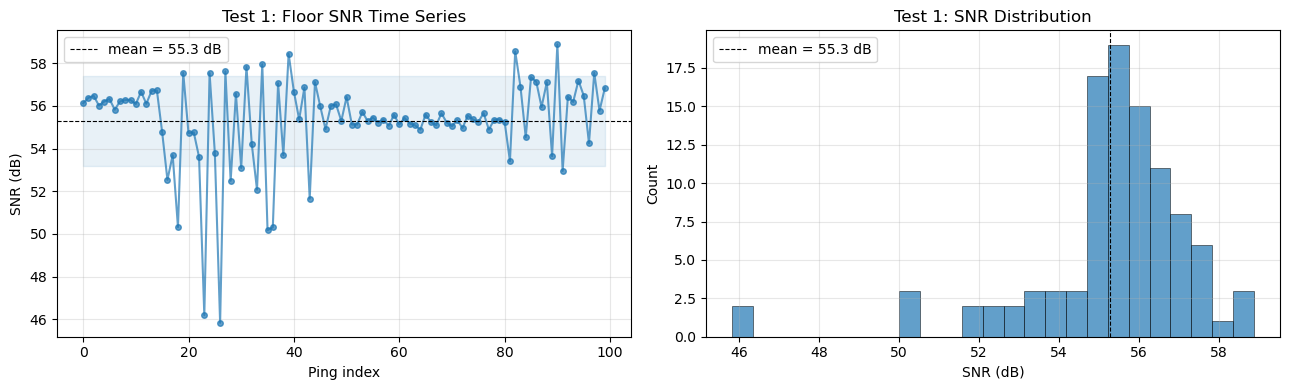

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 90→150 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 55.3 dB, std = 2.10 dB, min = 45.8 dB, max = 58.9 dB


In [3]:
snr_1 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T105726_100.mat'),
    test_num=1,
    description='22 mm ball bearing, moving, 0.0 dB TX'
)
all_results['Test 1'] = snr_1

## Test 2: 22 mm ball bearing, stationary, 0.0 dB TX

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T110424_100.mat` |
| **TX Power** | 0.0 dB |
| **Target** | 22 mm ball bearing |
| **Target State** | Stationary |
| **Chirp** | Upsweep (90 → 150 kHz) |
| **Pings** | 100 |
| **Notes** | 22 mm ball bearing, stationary, 0.0 dB TX |

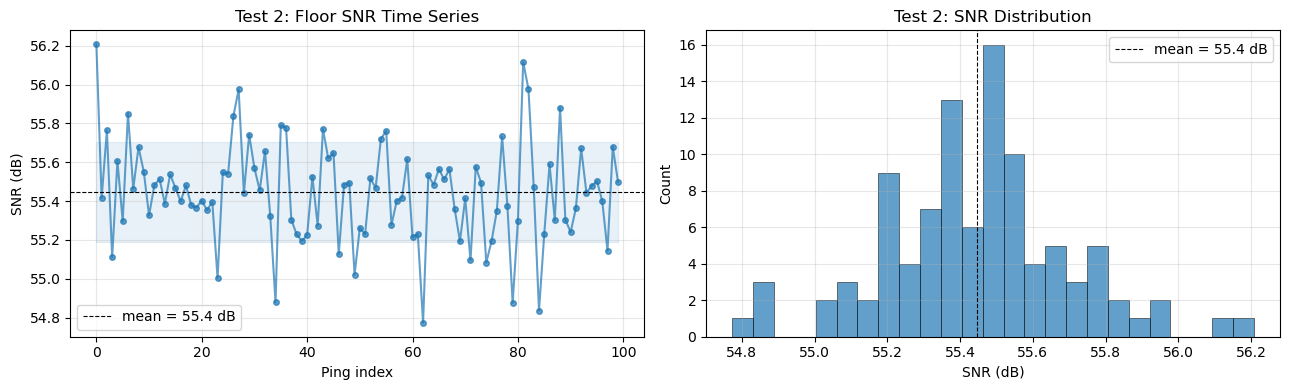

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 90→150 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 55.4 dB, std = 0.26 dB, min = 54.8 dB, max = 56.2 dB


In [4]:
snr_2 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T110424_100.mat'),
    test_num=2,
    description='22 mm ball bearing, stationary, 0.0 dB TX'
)
all_results['Test 2'] = snr_2

## Test 3: 22 mm ball bearing, stationary, +3.0 dB TX

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T110817_100.mat` |
| **TX Power** | +3.0 dB |
| **Target** | 22 mm ball bearing |
| **Target State** | Stationary |
| **Chirp** | Upsweep (90 → 150 kHz) |
| **Pings** | 100 |
| **Notes** | 22 mm ball bearing, stationary, +3.0 dB TX — compare with Test 2 for TX power effect |

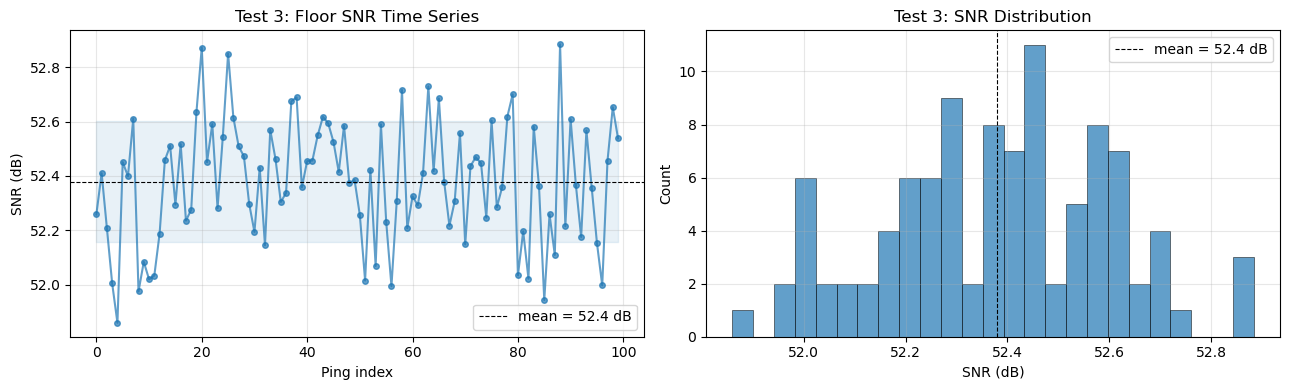

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 90→150 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 52.4 dB, std = 0.22 dB, min = 51.9 dB, max = 52.9 dB


In [5]:
snr_3 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T110817_100.mat'),
    test_num=3,
    description='22 mm ball bearing, stationary, +3.0 dB TX — compare with Test 2 for TX power effect'
)
all_results['Test 3'] = snr_3

## Test 4: No target, +3.0 dB TX

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T111929_100.mat` |
| **TX Power** | +3.0 dB |
| **Target** | None (empty water) |
| **Target State** | N/A |
| **Chirp** | Upsweep (90 → 150 kHz) |
| **Pings** | 100 |
| **Notes** | No target, +3.0 dB TX — baseline reverberation measurement |

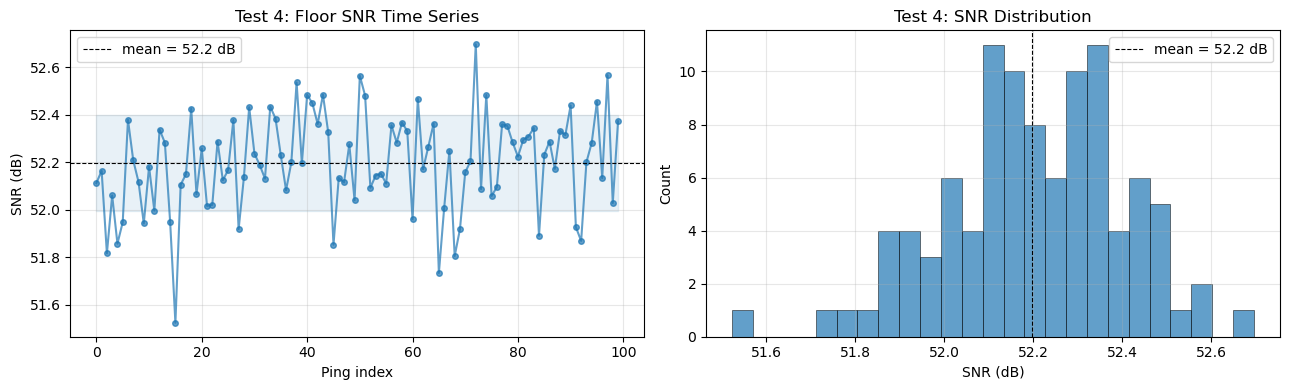

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 90→150 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 52.2 dB, std = 0.20 dB, min = 51.5 dB, max = 52.7 dB


In [6]:
snr_4 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T111929_100.mat'),
    test_num=4,
    description='No target, +3.0 dB TX — baseline reverberation measurement'
)
all_results['Test 4'] = snr_4

## Test 5: No target, -40.0 dB TX

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T112219_100.mat` |
| **TX Power** | -40.0 dB |
| **Target** | None (empty water) |
| **Target State** | N/A |
| **Chirp** | Upsweep (90 → 150 kHz) |
| **Pings** | 100 |
| **Notes** | No target, -40.0 dB TX — reduced power noise floor measurement |

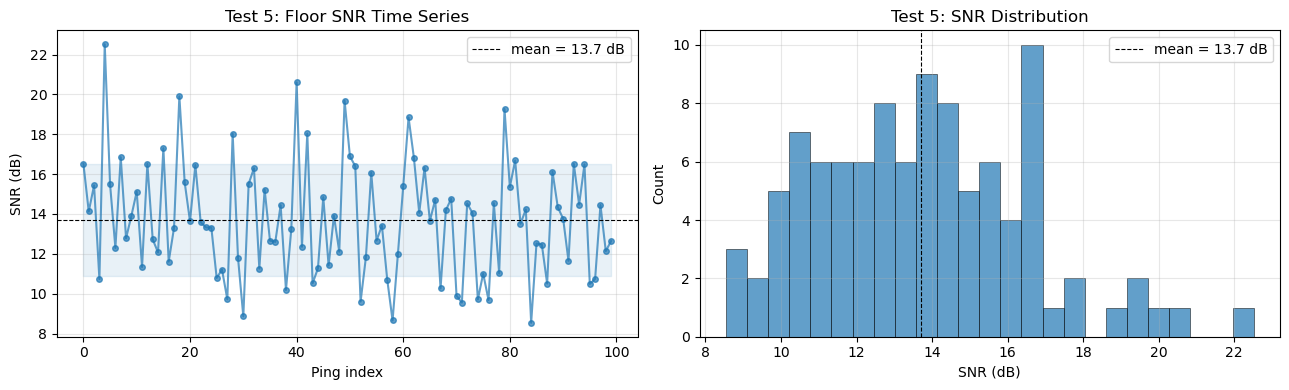

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 90→150 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 13.7 dB, std = 2.82 dB, min = 8.5 dB, max = 22.5 dB


In [7]:
snr_5 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T112219_100.mat'),
    test_num=5,
    description='No target, -40.0 dB TX — reduced power noise floor measurement'
)
all_results['Test 5'] = snr_5

## Summary — Cross-Test Comparison

Bar chart comparing mean floor SNR across all 5 tests,
with error bars showing ±1 standard deviation.

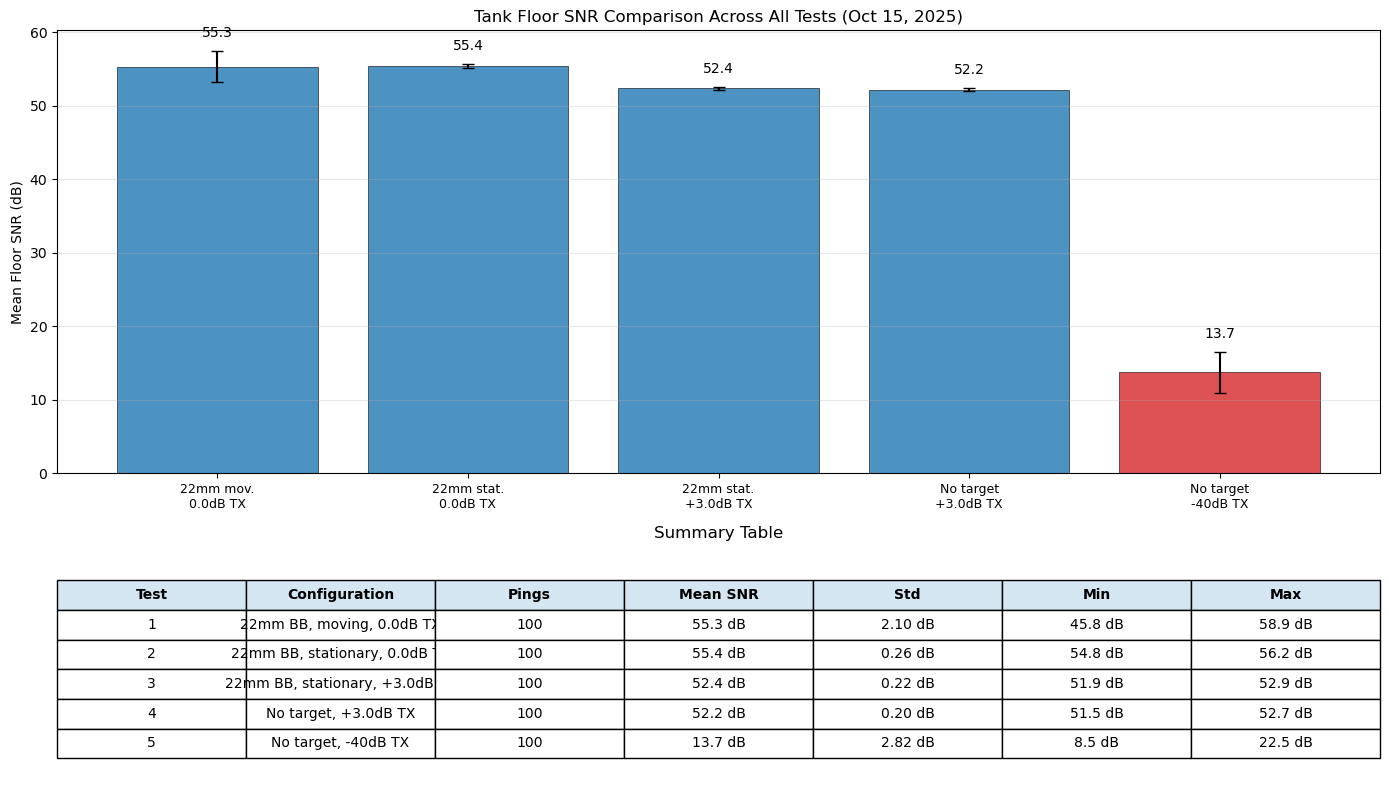


=== Floor SNR Summary ===
Test    Configuration                            Pings      Mean       Std       Min       Max
-------------------------------------------------------------------------------------
1       22mm BB, moving, 0.0dB TX                  100     55.3     2.10     45.8     58.9
2       22mm BB, stationary, 0.0dB TX              100     55.4     0.26     54.8     56.2
3       22mm BB, stationary, +3.0dB TX             100     52.4     0.22     51.9     52.9
4       No target, +3.0dB TX                       100     52.2     0.20     51.5     52.7
5       No target, -40dB TX                        100     13.7     2.82      8.5     22.5


In [8]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8),
                         gridspec_kw={'height_ratios': [2, 1]})

labels = list(all_results.keys())
means = [all_results[k].mean() for k in labels]
stds = [all_results[k].std() for k in labels]
x = np.arange(len(labels))

# Short descriptions for x-axis
short_labels = [
    '22mm mov.\n0.0dB TX',
    '22mm stat.\n0.0dB TX',
    '22mm stat.\n+3.0dB TX',
    'No target\n+3.0dB TX',
    'No target\n-40dB TX',
]

# ---- Top: bar chart ----
ax = axes[0]
colors = ['C0' if m > 20 else 'C3' for m in means]
bars = ax.bar(x, means, yerr=stds, capsize=4, color=colors,
              edgecolor='k', linewidth=0.5, alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(short_labels, fontsize=9)
ax.set_ylabel('Mean Floor SNR (dB)')
ax.set_title('Tank Floor SNR Comparison Across All Tests (Oct 15, 2025)')
ax.grid(True, alpha=0.3, axis='y')

# Annotate values
for i, (m, s) in enumerate(zip(means, stds)):
    ax.text(i, m + s + 1.5, f'{m:.1f}', ha='center', va='bottom', fontsize=10)

# ---- Bottom: summary table ----
ax = axes[1]
ax.axis('off')
table_data = [['Test', 'Configuration', 'Pings', 'Mean SNR', 'Std', 'Min', 'Max']]
configs = [
    '22mm BB, moving, 0.0dB TX',
    '22mm BB, stationary, 0.0dB TX',
    '22mm BB, stationary, +3.0dB TX',
    'No target, +3.0dB TX',
    'No target, -40dB TX',
]

for i, k in enumerate(labels):
    snr = all_results[k]
    table_data.append([
        f'{i+1}', configs[i], '100',
        f'{snr.mean():.1f} dB', f'{snr.std():.2f} dB',
        f'{snr.min():.1f} dB', f'{snr.max():.1f} dB'
    ])

table = ax.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
for j in range(len(table_data[0])):
    table[0, j].set_facecolor('#d4e6f1')
    table[0, j].set_text_props(fontweight='bold')
ax.set_title('Summary Table', fontsize=12, pad=15)

plt.tight_layout()
plt.show()

# Print summary
print('\n=== Floor SNR Summary ===')
print(f'{"Test":<7} {"Configuration":<40} {"Pings":>5}  {"Mean":>8}  {"Std":>8}  {"Min":>8}  {"Max":>8}')
print('-' * 85)
for i, k in enumerate(labels):
    snr = all_results[k]
    print(f'{i+1:<7} {configs[i]:<40} {100:>5}  '
          f'{snr.mean():>7.1f}  {snr.std():>7.2f}  {snr.min():>7.1f}  {snr.max():>7.1f}')

## Discussion

### Expected Patterns

1. **Tests 1–2 (0.0 dB TX, target moving vs stationary)**: Floor SNR should be
   similar regardless of target state, since the target at ~1.15 m is well-separated
   from the floor gate at 2.5–5.0 m. Any difference would indicate target scattering
   energy leaking into the floor/noise gates.

2. **Test 2 vs 3 (0.0 dB vs +3.0 dB TX, target stationary)**: The +3 dB increase
   in transmit power should produce a ~3 dB increase in floor SNR, since both signal
   and noise scale linearly with transmit voltage but the noise gate is dominated by
   ambient/electronic noise rather than reverberation.

3. **Test 3 vs 4 (+3.0 dB TX, target vs no target)**: Floor SNR should be nearly
   identical — the 22 mm target at 1.15 m should not affect the floor return at ~3 m.

4. **Test 5 (-40 dB TX, no target)**: With transmit power reduced by 43 dB relative
   to Test 4, the floor return should be well below the noise floor. This measures
   the system noise floor under reduced-power conditions.

### Key Comparisons

- **Test 1 vs 2**: Effect of target motion on floor SNR
- **Test 2 vs 3**: Effect of TX power (0.0 dB vs +3.0 dB) on floor SNR
- **Test 3 vs 4**: Effect of target presence on floor SNR
- **Test 4 vs 5**: Effect of TX power (+3.0 dB vs -40 dB) on floor SNR

### Results Analysis

**1. Target motion does not affect mean floor SNR, but increases variability.**
Test 1 (moving) = 55.3 dB vs Test 2 (stationary) = 55.4 dB — the means are essentially
identical. However, the standard deviation is dramatically different: 2.10 dB (moving) vs
0.26 dB (stationary). The moving target introduces ping-to-ping variability, likely from
changing multipath interference patterns as the target swings, even though the target gate
is well-separated from the floor gate.

**2. Higher TX power yields *lower* floor SNR — counterintuitive.**
Test 2 (0.0 dB TX) = 55.4 dB vs Test 3 (+3.0 dB TX) = 52.4 dB. The +3 dB TX power
setting produces **3.0 dB lower** floor SNR. In a purely linear, ambient-noise-limited
system, higher TX power should increase SNR. The observed inversion suggests the noise
gate [2.0, 2.5] m is **reverberation-limited** rather than ambient-noise-limited at these
power levels: increasing TX power raises both the floor return and the reverberation in
the noise gate, but the reverberation increases by more than the signal. This could occur
if the noise gate contains multipath energy (wall reflections, surface bounce) that scales
superlinearly with TX power, or if the higher power setting drives the transmit amplifier
into mild compression, reducing the effective chirp fidelity and matched filter gain.
This warrants further investigation.

**3. Target presence does not affect floor SNR.**
Test 3 (22 mm target, +3.0 dB) = 52.4 dB vs Test 4 (no target, +3.0 dB) = 52.2 dB.
The 0.2 dB difference is within measurement uncertainty, confirming the target at ~1.15 m
does not contaminate the floor or noise gates.

**4. -40 dB TX gives noise floor consistent with Nov 5.**
Test 5 (-40 dB TX) = 13.7 dB. This is in excellent agreement with the Nov 5 noise
floor measurements:

| Test | Configuration | Mean SNR |
|---|---|---|
| **Oct 15 Test 5** | **-40 dB TX, no target** | **13.7 dB** |
| Nov 5 Test 4 | Dummy load (65 Ω) | 13.3 dB |
| Nov 5 Test 10 | -80 dB TX, 22mm WC | 14.0 dB |
| Nov 5 Test 5 | Amp unpowered | 16.0 dB |

The ~13–14 dB matched-filter noise floor is reproducible across sessions and across
different methods of suppressing the acoustic signal (reduced TX power, dummy load,
-80 dB TX). This represents the fundamental noise floor of the echobot's matched
filter processing chain.

**5. Stationary measurements are extremely stable.**
Tests 2, 3, and 4 (all stationary or no-target) show remarkably low standard deviations
of 0.20–0.26 dB across 100 pings. This indicates the tank environment and system
electronics are very stable, and that ping-to-ping variability in moving-target tests
(std ~2–4 dB) is entirely attributable to target dynamics.

### Cross-Session Comparison (Oct 15 vs Nov 5)

| Metric | Oct 15 | Nov 5 | Notes |
|---|---|---|---|
| Upsweep, +3.0 dB TX, no target | 52.2 dB | 59.3 dB | **7.1 dB gap** |
| Upsweep, 0.0 dB TX (Oct) vs +3.0 dB (Nov) | 55.4 dB | 59.3 dB | 3.9 dB gap ≈ 3 dB TX difference |
| Noise floor (reduced TX) | 13.7 dB | 13.3–14.0 dB | Consistent |

The most notable cross-session finding is the **7.1 dB difference** between Oct 15 and
Nov 5 for the same nominal configuration (upsweep, +3.0 dB TX, no target). Possible
causes:

- **Tank setup differences**: The Nov 5 notes specify the transducer in the corner
  ~1 m from two sides, 30 cm below surface. The Oct 15 notes do not specify the exact
  position — a different placement could change the multipath environment and floor
  return geometry.
- **Water conditions**: Temperature and dissolved gas content affect absorption and
  sound speed, though the effect at ~3 m range should be small.
- **Amplifier/coupling variability**: The power amplifier output or transducer coupling
  may have differed between sessions.

Interestingly, the Oct 15 0.0 dB TX result (55.4 dB) is only 3.9 dB below the Nov 5
+3.0 dB result (59.3 dB), which is approximately the expected 3 dB TX power difference.
This suggests the Oct 15 0.0 dB setting may correspond to a similar effective acoustic
output as what the Nov 5 session achieved, and the Oct 15 +3.0 dB setting may be
anomalously low — possibly due to the reverberation-limiting effect identified in
finding #2 above.

### Key Takeaways

1. The **system noise floor is ~13–14 dB** and is reproducible across sessions.
2. **Stationary measurements** are extremely precise (std < 0.3 dB).
3. The **TX power vs SNR relationship is not straightforward** — higher power can reduce
   SNR in this reverberation-limited tank environment. This is important for operational
   parameter selection.
4. **Session-to-session variability** of ~7 dB for the same nominal configuration
   highlights the importance of controlling tank setup (transducer position, water
   conditions) for reproducible measurements.